# HMCTuning

Author: <b>Ignacio Peis</b>


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import *
from examples import *


/Users/ipeis/opt/anaconda3/envs/HMCTuning/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Sampling

Firstly, we need a function to return the objective, $\log p(x)$

In [2]:
## Gaussian Mixture

# Load the log probability function of MoG, and the initial proposal
logp = get_logp('wave')
mu0, var0 = initial_proposal('wave')   # [0, 0],  [0.01, 0.01]


You can see here how the distribution looks like:

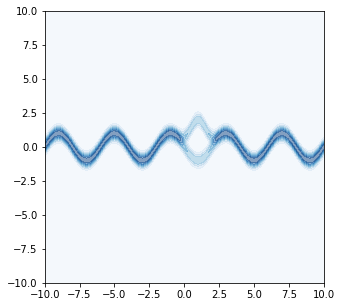

In [3]:
f, ax = plt.subplots(figsize=(5, 5))
plot_density('wave', ax)

Firstly, the HMC is initialized using:

In [4]:
# Create the HMC object
hmc = HMC(dim=2, logp=logp, T=5,  L=5, chains=100, chains_sksd=30, mu0=mu0, var0=var0, vector_scale=True)

To obtain 1000 samples from the HMC object, just run:

(-10.0, 10.0)

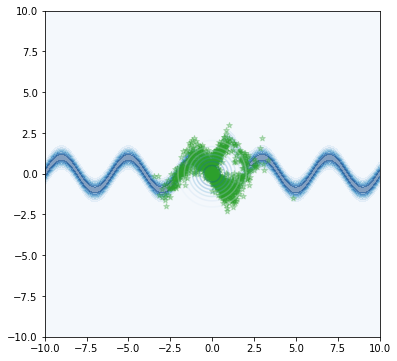

In [5]:
samples, chains = hmc.sample(chains=1000, mu0=mu0, var0=var0)

# Numpy samples for plotting with maplotlib
samples = samples.detach().numpy()

f, ax = plt.subplots(figsize=(6, 6))
plot_density('wave', ax)
ax.scatter(samples[0, :, 0], samples[0, :, 1], marker='*', color='tab:green', alpha=0.3)

xmin, xmax, ymin, ymax = get_grid_lims('wave')   
xgrid = np.linspace(xmin, xmax, 1000)
ygrid = np.linspace(ymin, ymax, 1000)
plot_bi_gaussian(mu0, var0, xgrid, ygrid, ax)
ax.set_xlim(xmin, xmax) 
ax.set_ylim(ymin, ymax) 



To fit the hyperparameters:

In [6]:
hmc.fit(steps=80)

HMC (objective=-0.145678): 100%|██████████| 80/80 [00:04<00:00, 16.54it/s]  


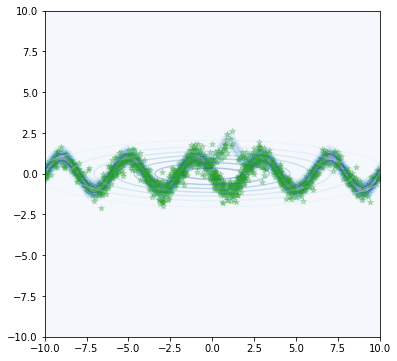

In [7]:
samples, chains = hmc.sample(chains=1000)

# Numpy samples for plotting with maplotlib
samples = samples.detach().numpy()

f, ax = plt.subplots(figsize=(6, 6))
plot_density('wave', ax)
ax.scatter(samples[0, :, 0], samples[0, :, 1], marker='*', color='tab:green', alpha=0.3)

mu0 = hmc.mu0.detach().numpy()
var0 = torch.exp(hmc.logvar0) * torch.exp(2*hmc.log_inflation)
var0 = var0.detach().numpy()

xmin, xmax, ymin, ymax = get_grid_lims('wave')   
xgrid = np.linspace(xmin, xmax, 1000)
ygrid = np.linspace(ymin, ymax, 1000)
plot_bi_gaussian(mu0, var0, xgrid, ygrid, ax)
ax.set_xlim(xmin, xmax) 
ax.set_ylim(ymin, ymax) 

plt.show()

Text(0.5, 0, 'step')

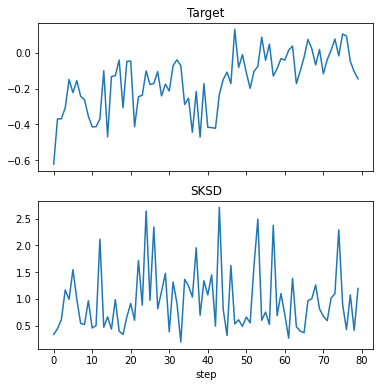

In [8]:
f, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

ax[0].plot(hmc.objective)
ax[0].set_title('Target')
ax[1].plot(hmc.sksd)
ax[1].set_title('SKSD')
plt.xlabel('step')
